# Chirp-taper example in a short bunch 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
sys.path.append('/Users/riverr/Documents/pyfel1d/main/')
from particles import ParticleLoader
from fel import OneDFELSolver, LinearTheory
import time

This notebook shows an example relevant to attosecond XFELs  in which a short bunch with an energy chirp lases in a tapered undulator to compensate the energy chirp.

# Simulation set up 

In [2]:
solver = OneDFELSolver(Lzhat=30, ## undulator length
                       Nzhat=2000, ## number of steps in undulator
                       Lzeta=20,
                       Nzeta=500,
                       time_independent=False)

In [3]:
## define beam profile 

beam_rms = 2
beam_zeta0 = solver.zeta_arr.mean()
beam_supergauss_n = 1

bg = 0.1

solver.chi = (1-bg)*np.exp(-(solver.zeta_arr - beam_zeta0)**(2*beam_supergauss_n)/(2*beam_rms**(2*beam_supergauss_n)))
solver.chi += bg

In [4]:
## initialize bunching profile 
## in this example, we use shotnoise style bunching with rms value 3e-4 and zero energy spread 

chirp_amp = 5
chirp_arr= -chirp_amp*np.gradient(solver.chi, solver.zeta_arr)[:,None]

chirp = chirp_amp*(1-bg)/beam_rms**2
print(chirp)
solver.generate_beam(bdes=1e-4, 
                     chirp_arr=chirp_arr, 
                     slice_espread_function=lambda Np: np.random.normal(0, 0.25, Np))


1.125


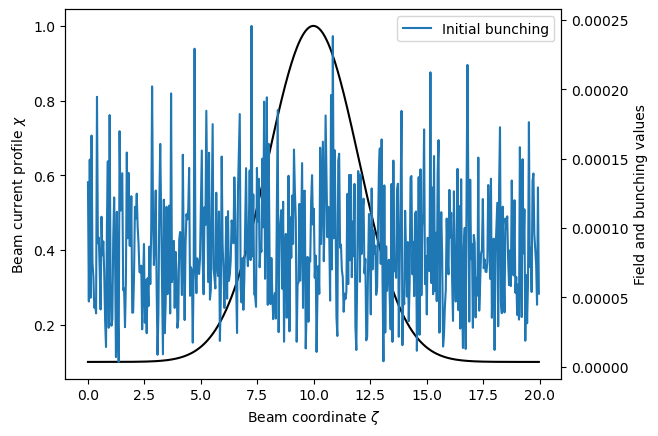

In [5]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(solver.zeta_arr, solver.chi, 'k')

ax2.plot(solver.zeta_arr, np.abs(solver.calculate_moments(1,0)), label='Initial bunching')
ax.set_xlabel(r'Beam coordinate $\zeta$')
ax.set_ylabel(r'Beam current profile $\chi$')
ax2.set_ylabel(r'Field and bunching values')
ax2.legend()

Text(0.5, 1.0, 'Beam phase space')

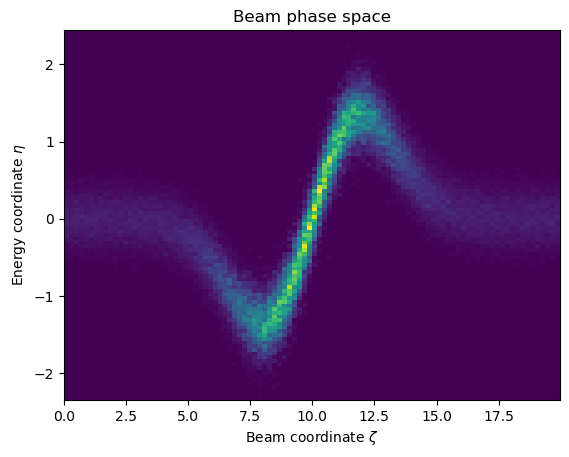

In [6]:
plt.hist2d(np.array([np.ones(solver.theta0.shape[1])*solver.zeta_arr[i] for i in range(solver.Nzeta)]).flatten(), solver.eta0.flatten(), [100,100], weights=np.array([np.ones(solver.theta0.shape[1])*solver.chi[i] for i in range(solver.Nzeta)]).flatten());
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Energy coordinate $\eta$')
plt.title('Beam phase space')

# Run simulation and look at results

In [7]:
%%time
solver.run_simulation(steps_between_store = 10, ## store the field every 10 steps 
                      verbose=True, ## print status in 10% intervals 
                      store_particles=True)

Found no input harmonics array, assuming only first harmonic present
Found no input taper array, assuming it is zero everywhere
Input seed field $a_0$ is unspecified, setting it to zero
Beginning simulation including harmonics: [1]
0% done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
Done
CPU times: user 2min 15s, sys: 5.62 s, total: 2min 21s
Wall time: 20.6 s


Text(0, 0.5, 'Undulator coordinate $\\hat{z}$')

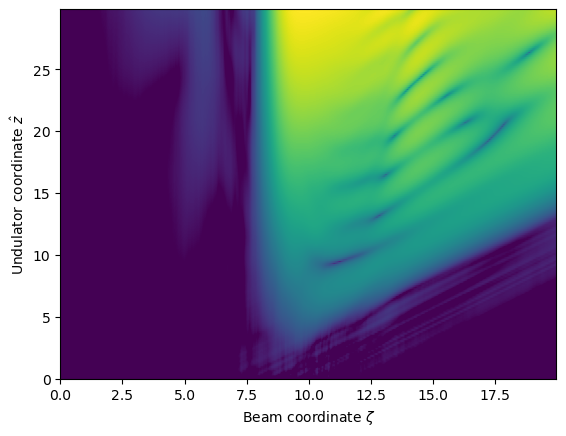

In [8]:
plt.imshow(1e-12+np.abs(solver.a_store)**2, aspect='auto', origin='lower', norm=LogNorm(vmin=1e-10), extent=[0, solver.zeta_arr.max(), 0, solver.zhat_store.max()])
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Undulator coordinate $\hat{z}$')


Text(0, 0.5, 'Average power $|a|^2$')

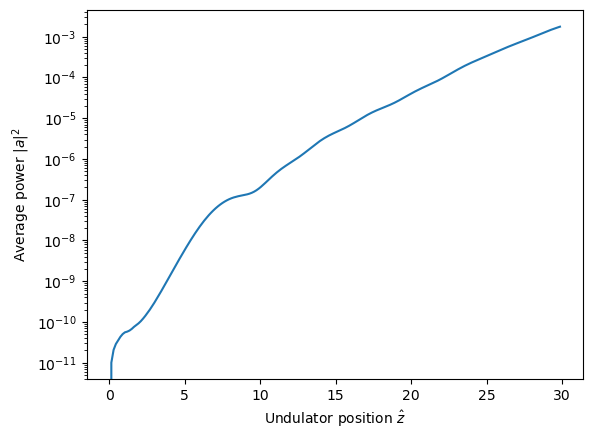

In [9]:
plt.plot(solver.zhat_store, (np.abs(solver.a_store)**2).mean(axis=-1))
plt.yscale('log')
plt.xlabel(r'Undulator position $\hat{z}$')
plt.ylabel(r'Average power $|a|^2$')

/var/folders/rx/p106nzns0lqg6mgzkh1lq9p93pr40t/T/ipykernel_51903/1004714052.py:8: RuntimeWarning: invalid value encountered in divide
  power_norm = power / power.max()


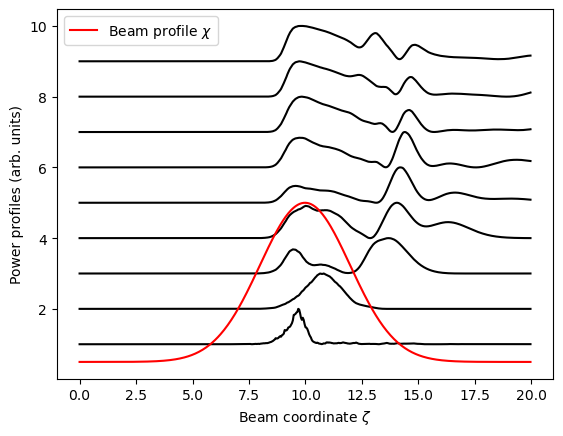

In [10]:
nplot = 10

zinds = np.linspace(0, len(solver.zhat_store)-1, nplot).astype(int)

for i in range(nplot):
    zind = zinds[i]
    power = np.abs(solver.a_store[zind])**2
    power_norm = power / power.max()
    plt.plot(solver.zeta_arr, i + power_norm, 'k')

plt.plot(solver.zeta_arr, nplot/2*solver.chi, 'r', label=r'Beam profile $\chi$')
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel('Power profiles (arb. units)')
plt.legend()


In [11]:
a_notaper = solver.a_store

## Now let's add the theoretically ideal linear taper 

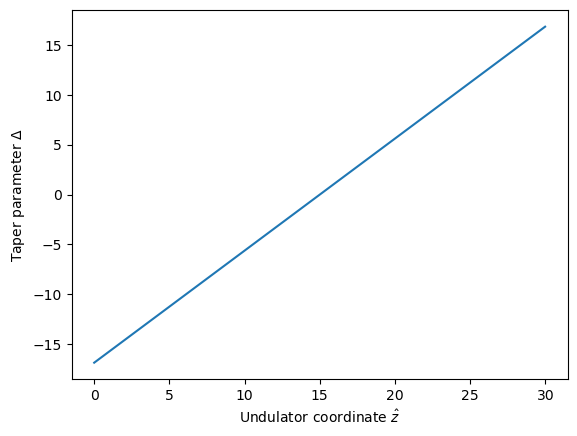

In [12]:
solver.taper = chirp*solver.zhat_arr
solver.taper -= solver.taper.mean()
plt.plot(solver.zhat_arr, solver.taper)
plt.ylabel(r'Taper parameter $\Delta$')
plt.xlabel(r'Undulator coordinate $\hat{z}$')
plt.show()

In [13]:
%%time
solver.run_simulation(steps_between_store = 10, ## store the field every 10 steps 
                      verbose=True, ## print status in 10% intervals 
                      store_particles=True)

Beginning simulation including harmonics: [1]
0% done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
Done
CPU times: user 2min 20s, sys: 5.51 s, total: 2min 25s
Wall time: 21.4 s


Text(0, 0.5, 'Undulator coordinate $\\hat{z}$')

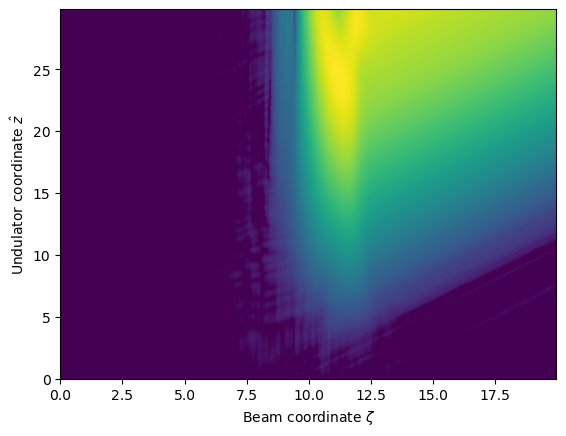

In [14]:
plt.imshow(1e-12+np.abs(solver.a_store)**2, aspect='auto', origin='lower', norm=LogNorm(vmin=1e-10), extent=[0, solver.zeta_arr.max(), 0, solver.zhat_store.max()])
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Undulator coordinate $\hat{z}$')


Text(0, 0.5, 'Average power $|a|^2$')

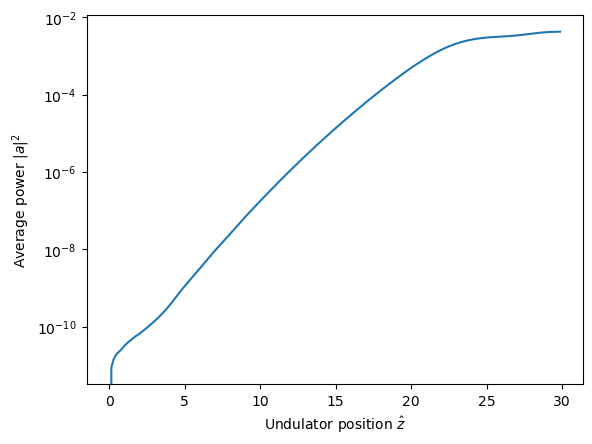

In [15]:
plt.plot(solver.zhat_store, (np.abs(solver.a_store)**2).mean(axis=-1))
plt.yscale('log')
plt.xlabel(r'Undulator position $\hat{z}$')
plt.ylabel(r'Average power $|a|^2$')

/var/folders/rx/p106nzns0lqg6mgzkh1lq9p93pr40t/T/ipykernel_51903/1004714052.py:8: RuntimeWarning: invalid value encountered in divide
  power_norm = power / power.max()


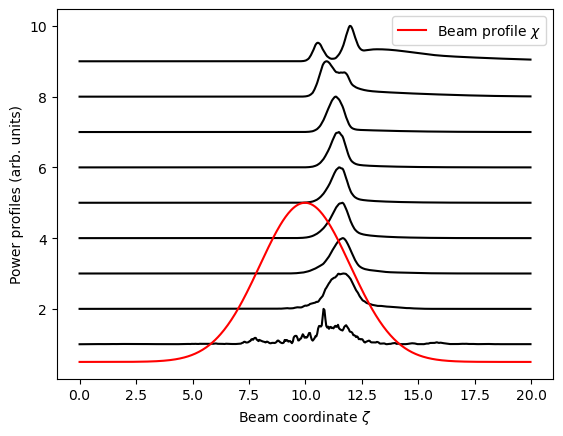

In [16]:
nplot = 10

zinds = np.linspace(0, len(solver.zhat_store)-1, nplot).astype(int)

for i in range(nplot):
    zind = zinds[i]
    power = np.abs(solver.a_store[zind])**2
    power_norm = power / power.max()
    plt.plot(solver.zeta_arr, i + power_norm, 'k')

plt.plot(solver.zeta_arr, nplot/2*solver.chi, 'r', label=r'Beam profile $\chi$')
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel('Power profiles (arb. units)')
plt.legend()


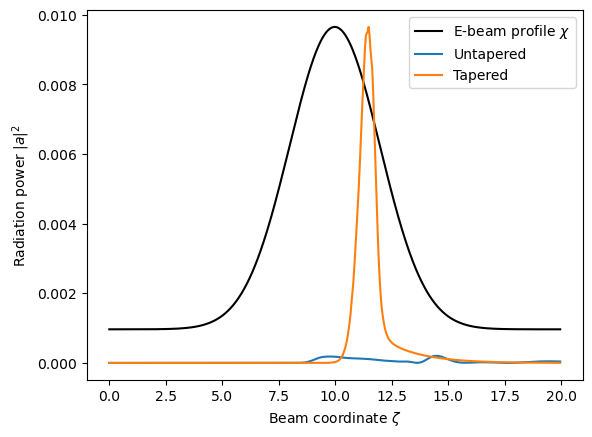

In [17]:
zplot = 20
i = np.argmin(np.abs(solver.zhat_store - zplot))
peak = np.max([np.max(np.abs(a)**2) for a in [solver.a_store[i], a_notaper[i]]])
plt.plot(solver.zeta_arr, solver.chi * peak, 'k', label=r'E-beam profile $\chi$')
plt.plot(solver.zeta_arr, np.abs(a_notaper[i])**2, label='Untapered')
plt.plot(solver.zeta_arr, np.abs(solver.a_store[i])**2, label='Tapered')
plt.xlabel(r'Beam coordinate $\zeta$')
plt.ylabel(r'Radiation power $|a|^2$')
plt.legend()